In [34]:
import numpy as np
from scipy.linalg import expm
import cvxpy as cp
import pickle
import matplotlib.pyplot as plt
from skimage import measure

In [18]:
N = 20

In [19]:
def annihilation_operator(N):
  a = np.zeros((N, N), dtype=complex)
  for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
  return a

In [20]:
def displacement_operator(alpha, N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    D_gen = alpha * a_dag - np.conj(alpha) * a
    return expm(D_gen)

In [21]:
def parity_operator(N):
    a = annihilation_operator(N)
    a_dag = a.conj().T
    number_operator = a_dag @ a
    return expm(1j * np.pi * number_operator)

In [22]:
def parity_operator_fock(N):
    return np.diag([(-1)**n for n in range(N)])

In [23]:
def wigner(alpha, rho, N):
    D = displacement_operator(alpha, N)
    P = parity_operator(N)
    D_dag = D.conj().T
    return (2 / np.pi) * np.real(np.trace(D @ P @ D_dag @ rho))

In [24]:
def get_measure_op(alpha, N):
  D = displacement_operator(alpha, N)
  P = parity_operator(N)
  D_dag = D.conj().T
  I = np.eye(N)
  return 0.5 * (I + D @ P @ D_dag)

In [25]:
def sample_measurements_operators(X, Y, Z, N, num_samples=100):
    I = np.eye(N)
    P = parity_operator(N)

    total_points = len(X) * len(Y)
    sample_indices = np.random.choice(total_points, num_samples, replace=False)

    alpha_samples = []
    w_exp_measurements = []
    measurement_operators = []

    for idx in sample_indices:
        i = idx // len(Y)
        j = idx % len(Y)

        x = X[i]
        y = Y[j]
        wigner_value = Z[i][j]

        alpha_k = x + 1j * y
        w_k = 0.5 * (1 + (np.pi / 2) * wigner_value)

        alpha_samples.append(alpha_k)
        w_exp_measurements.append(w_k)
        measurement_operators.append(get_measure_op(alpha_k, N))

    return w_exp_measurements, measurement_operators

In [26]:
def reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS'):
    # Define the variable (density matrix) as a complex matrix.
    rho = cp.Variable((N, N), complex=True)

    # Define constraints:
    #  - Hermitian: rho == rho.H
    #  - Positive semidefinite: rho >> 0 replaced by using a zero matrix
    #  - Normalized: trace(rho) == 1
    constraints = [
        rho == rho.H,                   # Hermitian constraint
        rho >> np.zeros((N, N)),         # Positive semidefinite constraint
        cp.trace(rho) == 1              # Trace equals 1
    ]

    # Build the objective function (least squares formulation)
    objective_terms = []
    for i in range(len(measurement_operators)):
        E_k_numpy = measurement_operators[i]  # measurement operator as a numpy array
        w_k = w_exp_measurements[i]             # experimental measurement value

        # The term is the squared difference of the predicted measurement value
        # (given by trace(E_k @ rho)) and the experimental outcome.
        term = cp.square(cp.abs(cp.trace(E_k_numpy @ rho) - w_k))
        objective_terms.append(term)

    # Formulate the overall optimization objective by summing the individual terms.
    objective = cp.Minimize(cp.sum(objective_terms))

    # Define and solve the optimization problem.
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver)

    return rho.value, prob


In [53]:
file_path = '../data/synthetic/noisy_wigner_4.pickle'
with open(file_path, 'rb') as f:
    data = pickle.load(f)
    X, Y, Z = data

In [29]:
w_exp_measurements, measurement_operators = sample_measurements_operators(X, Y, Z, N)
reconstructed_rho, prob = reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')

In [30]:
def plot_wigner_comparison(file_path, num_samples):
    with open(file_path, 'rb') as f:
        X, Y, Z = pickle.load(f)

    w_exp_measurements, measurement_operators = sample_measurements_operators(X, Y, Z, N, num_samples)

    reconstructed_rho, prob = reconstruct_density_matrix(w_exp_measurements, measurement_operators, N, solver='SCS')

    reconstructed_Z = np.zeros_like(Z, dtype=float)

    for i in range(len(X)):
        for j in range(len(Y)):
            alpha = X[i] + 1j * Y[j]
            reconstructed_Z[j, i] = wigner(alpha, reconstructed_rho, N)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]

    im0 = axs[0].imshow(Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_title('Original Wigner Function')
    fig.colorbar(im0, ax=axs[0], label='Wigner Function')

    im1 = axs[1].imshow(reconstructed_Z, extent=extent, origin='lower', cmap='jet', aspect='auto')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    axs[1].set_title('Reconstructed Wigner Function')
    fig.colorbar(im1, ax=axs[1], label='Wigner Function')

    plt.tight_layout()
    plt.show()

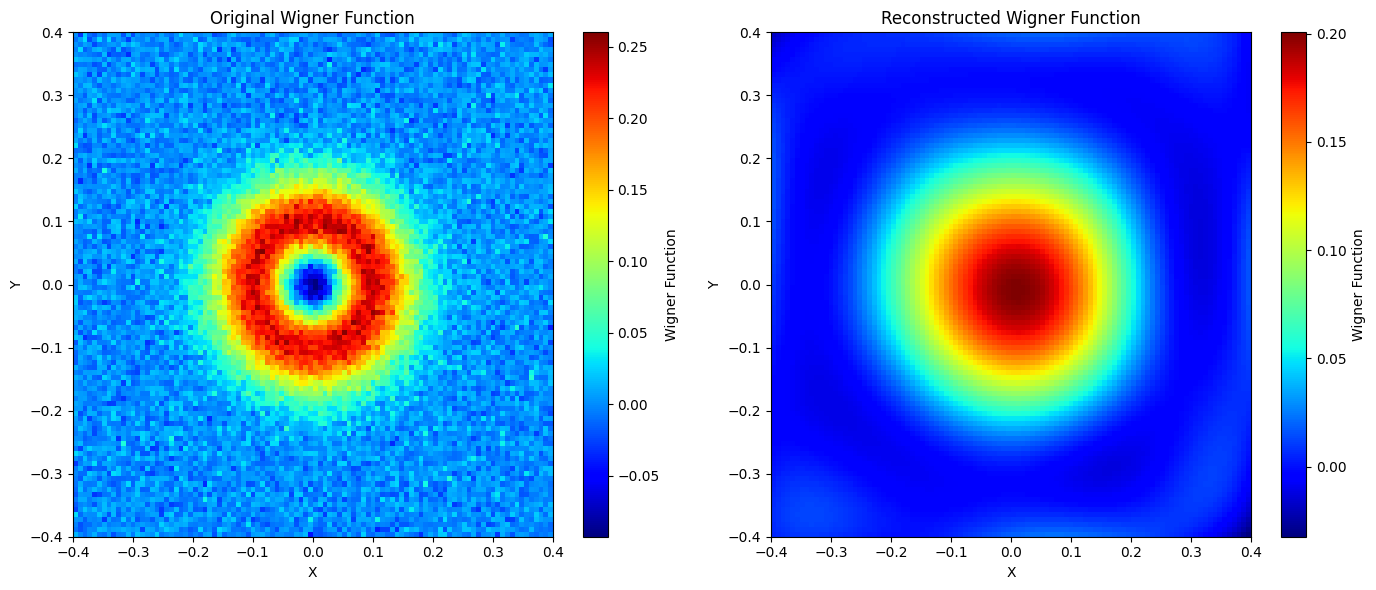

In [33]:
num_samples = 500
plot_wigner_comparison(file_path, num_samples)

[array([[722.02890967, 572.        ],
       [722.        , 571.97730374],
       [721.96096923, 572.        ],
       [722.        , 572.10973733],
       [722.02890967, 572.        ]]), array([[723.03154903, 580.        ],
       [723.        , 579.9619241 ],
       [722.97771076, 580.        ],
       [723.        , 580.02491811],
       [723.03154903, 580.        ]]), array([[730.14550884, 577.        ],
       [730.        , 576.79346146],
       [729.87340925, 577.        ],
       [730.        , 577.13681045],
       [730.14550884, 577.        ]]), array([[732.34243095, 584.        ],
       [732.        , 583.7549601 ],
       [731.65490288, 584.        ],
       [732.        , 584.38969147],
       [732.34243095, 584.        ]]), array([[733.0605333 , 566.        ],
       [733.        , 565.81523818],
       [732.93731394, 566.        ],
       [733.        , 566.07832053],
       [733.0605333 , 566.        ]]), array([[733.09072864, 581.        ],
       [733.        , 580.8

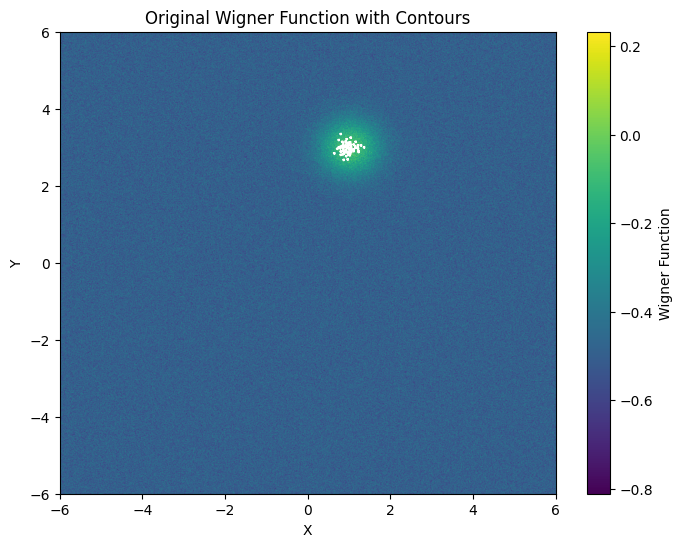

[np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.False_,
 np.False_,
 np.False_,
 np.True_,
 np.False_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.True_,
 np.False_,
 np.True_,
 np.False_,
 np.False_]

In [89]:
# print the original wigner function with contour finding atop it
def contour_mask(X, Y, Z):
    contour_size = 0.03
    length = 2

    fig, ax = plt.subplots(figsize=(8, 6))
    extent = [X.min(), X.max(), Y.min(), Y.max()]
    im = ax.imshow(Z, extent=extent, origin='lower', aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Original Wigner Function with Contours')

    contours = measure.find_contours(Z, contour_size)
    print(contours)
    for contour in contours:
        ax.plot(X[contour[:, 1].astype(int)], Y[contour[:, 0].astype(int)], color='white')
    fig.colorbar(im, label='Wigner Function')
    plt.show()

    perimeters = list(map(lambda x: np.sqrt(np.diff(x, axis=0)**2).sum(), contours))
    return list(map(lambda x: x > length, perimeters))

contour_mask(X, Y, Z)